In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime, timedelta
# from fbprophet import Prophet

In [2]:
dfevents = pd.read_csv('../../data/ecommerce/events.csv')
dfevents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype  
---  ------         -----  
 0   timestamp      int64  
 1   visitorid      int64  
 2   event          object 
 3   itemid         int64  
 4   transactionid  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 105.1+ MB


In [3]:
def unix_time_convert(df):
    times=[]  # convert from unix time format
    for i in df['timestamp']:
        times.append(datetime.datetime.fromtimestamp(i//1000.0))
    df['timestamp']=times
    return df

In [4]:
dfevents = unix_time_convert(dfevents)
dfevents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 105.1+ MB


In [5]:
dfevents.sort_values('timestamp').head()

,timestamp,visitorid,event,itemid,transactionid
1462974,2015-05-02 21:00:04,693516,addtocart,297662,NaN
1464806,2015-05-02 21:00:11,829044,view,60987,NaN
1463000,2015-05-02 21:00:13,652699,view,252860,NaN
1465287,2015-05-02 21:00:24,1125936,view,33661,NaN
1462955,2015-05-02 21:00:26,693516,view,297662,NaN


In [6]:
dfpurch = dfevents.loc[dfevents['event'] == 'transaction', ['timestamp', 'visitorid', 
                                                           'itemid', 'event']]
dfpurch = dfpurch.sort_values('timestamp')
dfpurch.shape

(22457, 4)

In [7]:
# dfpurch.sort_values('timestamp').head()
dfpurch.rename(columns={'timestamp':'ds'}, inplace=True)
dfpurch.head(2)

,ds,visitorid,itemid,event
1465072,2015-05-02 21:27:21,869008,40685,transaction
1463096,2015-05-02 21:35:01,345781,438400,transaction


In [8]:
# df.resample wants the index to be timestamp (BUT)
# For DataFrame objects, the keyword on can be used to specify the column instead 
# of the index for resampling.
dfpurch.resample('D', on="ds").count().tail(3)

,ds,visitorid,itemid,event
ds,,,,
2015-09-15,145,145,145,145
2015-09-16,111,111,111,111
2015-09-17,48,48,48,48


In [9]:
dfday = dfpurch.resample('D', on="ds").count()
dfday = dfday[['event']]
dfday.reset_index(inplace=True)
dfday.rename(columns={'event':'y'}, inplace=True)
print(dfday.shape)
dfday = dfday.iloc[1:-1]  # remove partial days
print(dfday.shape)
dfday.tail(3)

(139, 2)
(137, 2)


,ds,y
135,2015-09-14,173
136,2015-09-15,145
137,2015-09-16,111


In [10]:
# dfday.describe()
dfday.describe().loc['mean']

y    163.474453
Name: mean, dtype: float64

In [11]:
# matplotlib.style.available
# dfday.to_pickle('../../data/time_ecom/dfday.pkl')

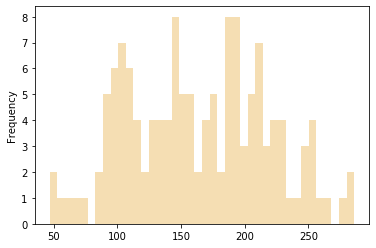

In [12]:
dfday['y'].plot(kind='hist', bins=40, color='wheat')
# dfday['y'].plot(kind='kde', color='wheat')

In [55]:
# 'Daily Purchases'
# 'Mean Purchases'
# ax.annotate('163.5 Mean Daily Purchases', xy=(0.6, 0.5),  xycoords='axes fraction',
#             xytext=(0.53, 0.17), textcoords='axes fraction', fontsize=14, 
#             arrowprops=dict(facecolor='black', shrink=0.05, width=2),
#             horizontalalignment='right', verticalalignment='top',
#             )
# dfdayplot.head()
ticks_full = np.arange(datetime(2015,5,12), datetime(2015,9,16), timedelta(weeks=4))
ticks_full
print(dfdayplot.index.values[0], dfdayplot.index.values[-1])

2015-05-03T00:00:00.000000000 2015-09-16T00:00:00.000000000


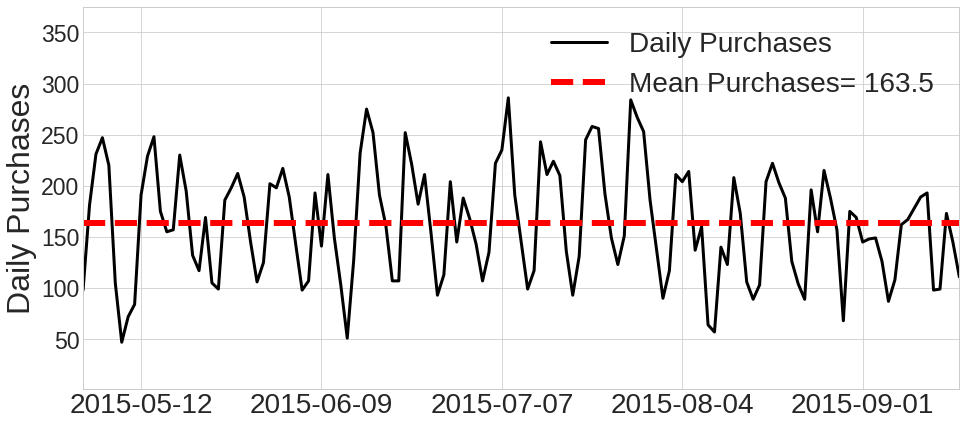

In [62]:
# plt.style.use('seaborn-white')
# plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
dfdayplot = dfday.rename(columns={'y': 'Daily Purchases', 
                                  'ds': 'time'}).set_index('time')

matplotlib.rc('xtick', labelsize=28) 
matplotlib.rc('ytick', labelsize=23)
matplotlib.rc('lines', linewidth=6, color='red')
fig, ax = plt.subplots(figsize=(13.5,6))
# dfdayplot.plot(ax=ax, legend=True, color='black', linewidth=3) # or 'tan'
ax.plot(dfdayplot['Daily Purchases'], color='black', linewidth=3, label="Daily Purchases")
# ax.set_label('Daily Purchases')
ax.axhline(163.47, label='Mean Purchases= 163.5', linestyle='--')

ax.set_xlim(dfdayplot.index.values[0], dfdayplot.index.values[-1])
ax.set_xticks(ticks_full)

ax.set_xlabel(None)
ax.set_ylabel("Daily Purchases", fontsize=32)
ax.set_ylim(1, 375)
plt.legend(fontsize=28, loc='upper right') # 'upper right' 'best'
# plt.ylabel('Daily Purchase')
plt.tight_layout(pad=1)
# plt.savefig('../img/data_timeseries.png', dpi=100)

In [14]:
# testing the split for train test
test_len = 28
print(dfday.shape)
df_train = dfday[:-test_len]
df_test = dfday[-test_len:]
print(df_train.shape, df_test.shape)

(137, 2)
(109, 2) (28, 2)


In [15]:
# stacked horizontal bar graph for event type counts
category_names = ['2,664,312 Product Views', '69,332 Add To Cart', 
                  '22,457 Product Purchases']
results = {'Data Events': [2664312, 69332, 22457]}
# results[0] // results[2]  # 118 views per 1 purchase

In [16]:
scrap = {
    'Question 1': [10, 15, 17, 32, 26],
    'Question 2': [26, 22, 29, 10, 13]}
def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('Blues')(
        np.linspace(0.25, 0.95, data.shape[1]))

    fig, ax = plt.subplots(figsize=(13.5, 1.5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
#         text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        text_color = 'black'
#         for y, (x, c) in enumerate(zip(xcenters, widths)):
#             ax.text(x, y, str(int(c)), ha='center', va='center',
#                     color=text_color, fontsize=18)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize=18)

    return fig, ax

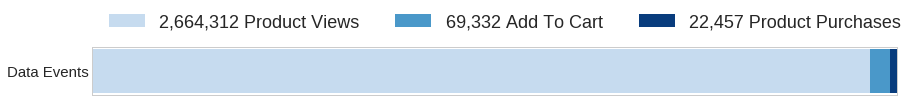

In [17]:
figbar, axbar = survey(results, category_names)
plt.tight_layout(pad=1)
# plt.savefig('../img/events_hbar.png', dpi=100)